In [1]:
'''1. Capture a 10 sec video footage using the camera. The footage should be taken with the camera in hand
and you need to pan the camera slightly from left-right or right-left during the 10 sec duration. Pick any
image frame from the 10 sec video footage. Pick a region of interest corresponding to an object in the
image. Crop this region from the image. Then use this cropped region to compare with randomly picked
10 images in the dataset of 10 sec video frames, to see if there is a match for the object in the scenes from
the 10 images. For comparison use sum of squared differences (SSD) or normalized correlation.'''

'1. Capture a 10 sec video footage using the camera. The footage should be taken with the camera in hand\nand you need to pan the camera slightly from left-right or right-left during the 10 sec duration. Pick any\nimage frame from the 10 sec video footage. Pick a region of interest corresponding to an object in the\nimage. Crop this region from the image. Then use this cropped region to compare with randomly picked\n10 images in the dataset of 10 sec video frames, to see if there is a match for the object in the scenes from\nthe 10 images. For comparison use sum of squared differences (SSD) or normalized correlation.'

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve,convolve2d
import math
from PIL import Image
import numpy as np 
import copy
from collections import deque

In [3]:
#Recorder video using rgbvideo python file
#The video is in ../supportingFiles/vid2.mov
#Load the video
#Create the data set

vidcap = cv2.VideoCapture('../supportingFiles/vid2.mp4')
success,image = vidcap.read()
count = 0
while success:
    success,image = vidcap.read()
    if count%30==0 :
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      cv2.imwrite("../supportingFiles/frame%d.jpg" % count, gray_image)     # save frame as JPEG file      
      print('Stored a frame in frame%d.jpg'%count, success)
    count += 1


Stored a frame in frame0.jpg True
Stored a frame in frame30.jpg True
Stored a frame in frame60.jpg True
Stored a frame in frame90.jpg True
Stored a frame in frame120.jpg True
Stored a frame in frame150.jpg True
Stored a frame in frame180.jpg True
Stored a frame in frame210.jpg True
Stored a frame in frame240.jpg True
Stored a frame in frame270.jpg True
Stored a frame in frame300.jpg True
Stored a frame in frame330.jpg True
Stored a frame in frame360.jpg True
Stored a frame in frame390.jpg True
Stored a frame in frame420.jpg True
Stored a frame in frame450.jpg True


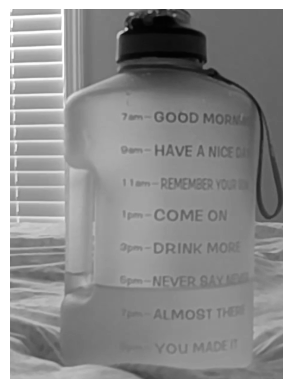

In [4]:
#The template image is a bottle
patch= cv2.imread("../supportingFiles/template.png", 0)
plt.axis('off')
plt.imshow(patch,cmap='gray', vmin=0, vmax=255)
plt.show()

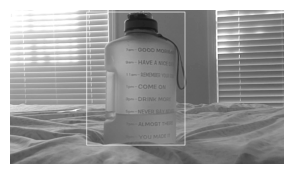

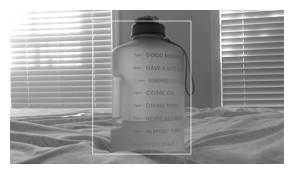

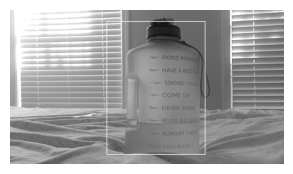

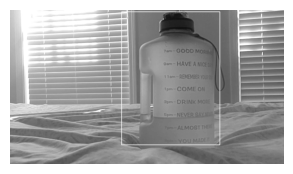

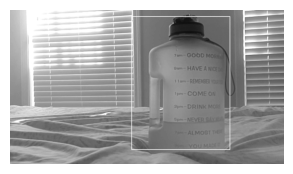

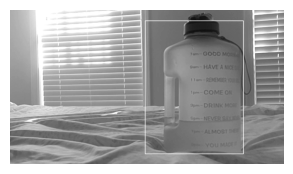

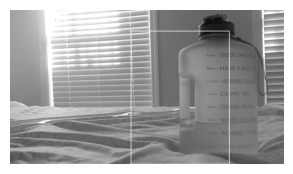

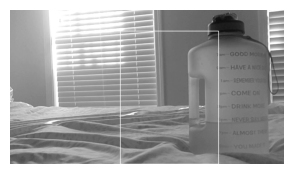

In [5]:
for i in range(0,240,30):
    gray = cv2.imread("../supportingFiles/frame%d.jpg"%i, 0)
    patch= cv2.imread("../supportingFiles/template.png", 0)
    # img is the image to search
    # patch is the template
    # Create Summed of Squared Differences with patch
    #Used sum of squares differences
    ssd = cv2.matchTemplate(gray, patch, cv2.TM_SQDIFF_NORMED) 
    # find min for match with SQDIFF_NORMED
    point = np.where(ssd == ssd.min())
    y = point[0][0]
    x = point[1][0]
    w = len(patch[0])
    h = len(patch)
    # Draw Rectangle
    plt.figure(figsize = (20,2))
    cv2.rectangle(gray, (x, y), (x+w, y+h), (255, 2, 1), 2)
    plt.axis('off')
    plt.imshow(gray,cmap='gray', vmin=0, vmax=255)
    plt.show()


In [6]:
#question1 is done

In [7]:
'''2. Implement the motion tracking equation from fundamental principles. Select any 2 consecutive frames
from the set from problem 1 and compute the motion function estimates. Conduct image registration to
realign the frames. Repeat test for all consecutive pairs of frames in the video.'''

'2. Implement the motion tracking equation from fundamental principles. Select any 2 consecutive frames\nfrom the set from problem 1 and compute the motion function estimates. Conduct image registration to\nrealign the frames. Repeat test for all consecutive pairs of frames in the video.'

In [8]:
def image_registration(img1, img2):
    # Open the image files.
    img1_color = cv2.imread(img1)  # Image to be aligned.
    img2_color = cv2.imread(img2)    # Reference image.
 
    # Convert to grayscale.
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape

    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    # Sort matches on the basis of their Hamming distance.
    matches.sorted(key = lambda x: x.distance)

    # Take the top 90 % matches forward.
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)

    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt

    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

    # Use this matrix to transform the
    # colored image wrt the reference image.
    transformed_img = cv2.warpPerspective(img1_color,
                        homography, (width, height))

    # Plot the output images.
    plt.axis('off')
    plt.imshow(transformed_img,cmap='gray', vmin=0, vmax=255)
    plt.show()

In [9]:
#For computing motion tracking function for two images
def motionTrackingFunction(img1,img2):
    Iref=img1
    Inext=img2
    Iref=np.array(Iref).astype(np.float32)
    Inext=np.array(Inext).astype(np.float32)
    kernel_x = np.array([[-1., 1.], [-1., 1.]])*.25
    kernel_y = np.array([[-1., -1.], [1., 1.]])*.25
    kernel_t = np.array([[1., 1.], [1., 1.]])*.25
    Iref = Iref / 255. 
    Inext = Inext / 255. 
    Ix=cv2.filter2D(Iref,-1,kernel=kernel_x)
    Iy=cv2.filter2D(Iref,-1,kernel=kernel_y)
    It=cv2.filter2D(Iref,-1,kernel=kernel_t)+cv2.filter2D(Inext,-1,kernel=kernel_x)
    Ix,Iy,It=np.array(Ix),np.array(Iy),np.array(It)
    u=np.divide(It,np.sqrt(np.square(Ix)+np.square(Iy)))
    return u

for i in range(0,240,30):
    Iref=cv2.imread('../supportingFiles/frame%d.jpg'%i,cv2.IMREAD_GRAYSCALE)
    Inext=cv2.imread('../supportingFiles/frame%d.jpg'%(i+30),cv2.IMREAD_GRAYSCALE)
    print("Motion function estamite for frame" + str(i) + " frame" + str(i+30) + str(motionTrackingFunction(Iref,Inext)))
    #print("Image registration to realign frames")
    #image_registration('../supportingFiles/frame%d.jpg'%i,'../supportingFiles/frame%d.jpg'%(i+30))

Motion function estamite for frame0 frame30[[       inf        inf        inf ...  63.646553  63.375027  58.250008]
 [       inf        inf        inf ...  63.646637  63.375122  58.250008]
 [       inf        inf        inf ...  45.21071   45.500004  45.437504]
 ...
 [107.51744  108.1499   108.1499   ... 239.00212  167.5      167.5     ]
 [109.41482  110.04728  121.622375 ... 239.70923  168.50002  168.50002 ]
 [124.80437  124.097244 121.622375 ... 239.70923         inf 241.83055 ]]
Motion function estamite for frame30 frame60[[       inf        inf        inf ... 134.25002  104.92215  104.92244 ]
 [       inf        inf        inf ... 134.25002  104.92184  104.922165]
 [       inf        inf        inf ...  77.4989    91.00001   77.49875 ]
 ...
 [ 67.47367   67.47367   64.8267   ... 159.06294  156.53275  155.26785 ]
 [189.41959  189.41959  100.00027  ... 249.00002  348.60367  348.60367 ]
 [420.7286   420.7286   104.29806  ... 247.00002  245.5      347.89655 ]]
Motion function estamite 

/var/folders/x9/sh05kd1s18d0j0dhr95mm6w80000gn/T/ipykernel_52275/3118495568.py:16: RuntimeWarning: divide by zero encountered in divide
  u=np.divide(It,np.sqrt(np.square(Ix)+np.square(Iy)))


In [10]:
#question2 is done


In [11]:
'''3. For the video (problem 1) you have taken, plot the optical flow vectors on each frame. (i) treating every
previous frame as a reference frame (ii) treating every 11th frame as a reference frame (iii) treating every
31st frame as a reference frame'''

'3. For the video (problem 1) you have taken, plot the optical flow vectors on each frame. (i) treating every\nprevious frame as a reference frame (ii) treating every 11th frame as a reference frame (iii) treating every\n31st frame as a reference frame'

In [12]:
#On running the code block output is shown

def opticalFlow(referenceFrameSec):
    cap = cv2.VideoCapture("../supportingFiles/vid2.mp4")
    ret, first_frame = cap.read()
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(first_frame)
    mask[..., 1] = 255
    i=1
    while(cap.isOpened()):
        ret, frame = cap.read()
        cv2.imshow("Input Window", frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Calculates dense optical flow by Farneback method
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,None,0.5, 3, 15, 3, 5, 1.2, 0)
        # Computes the magnitude and angle of the 2D vectors
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Sets image hue according to the optical flow
        # direction
        mask[..., 0] = angle * 180 / np.pi / 2
        # Sets image value according to the optical flow
        # magnitude (normalized)
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        # Converts HSV to RGB (BGR) color representation
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        #pens a new window and displays the output frame
        cv2.imshow("dense optical flow", rgb)
        # Updates previous frame
        if (referenceFrameSec == 1):
            prev_gray = gray
        elif (referenceFrameSec != 1):
            if i%referenceFrameSec == 0:
                prev_gray = gray    
        if(i%30 ==0 ):
            plt.axis('off')
            plt.imshow(rgb,cmap='gray', vmin=0, vmax=255)
            plt.show()
                
        i=i+1
        # Frames are read by intervals of 1 millisecond. The
        # programs breaks out of the while loop when the
        # user presses the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

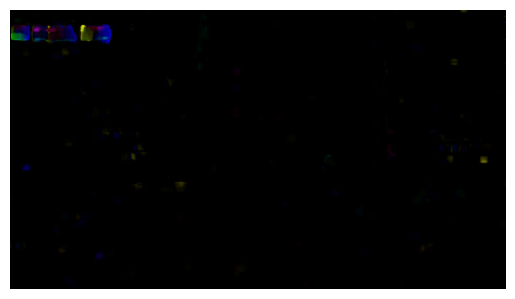

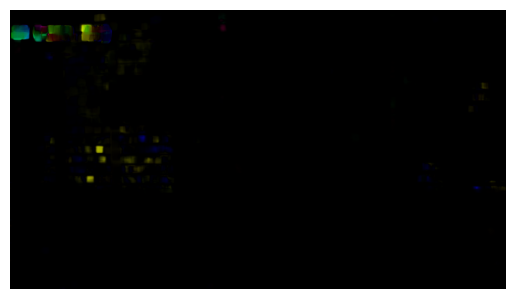

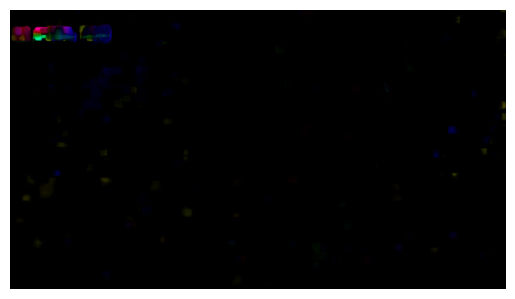

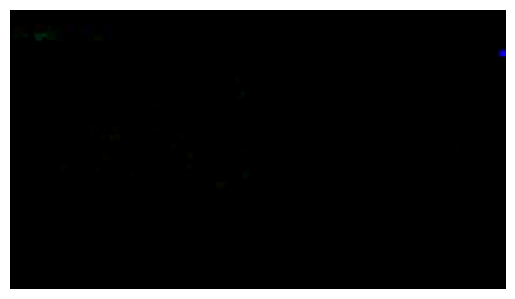

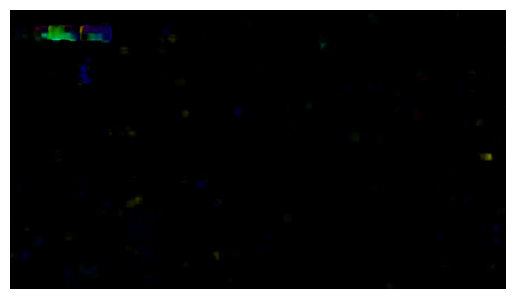

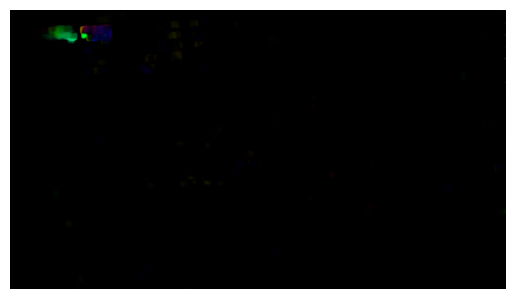

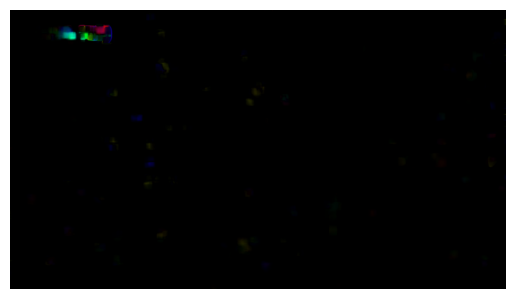

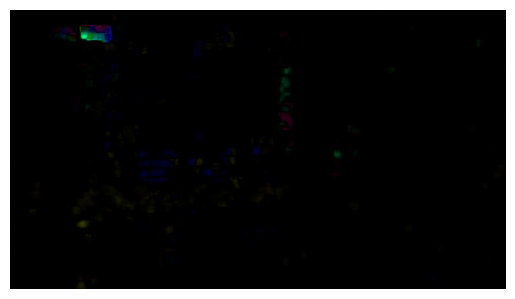

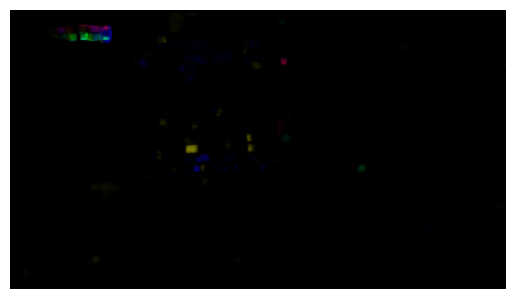

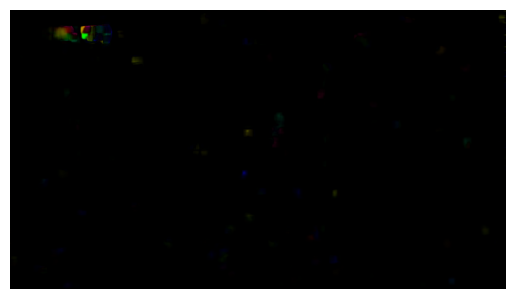

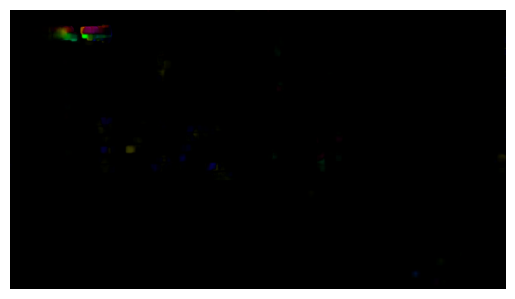

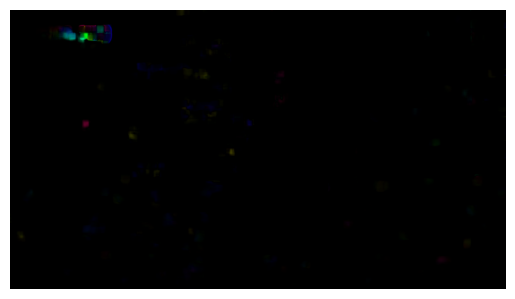

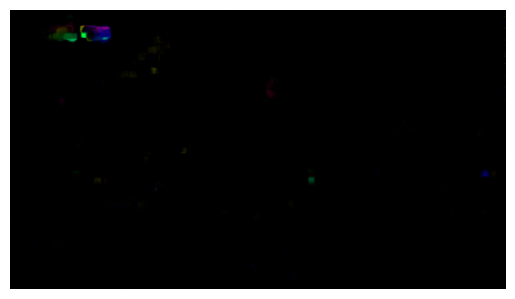

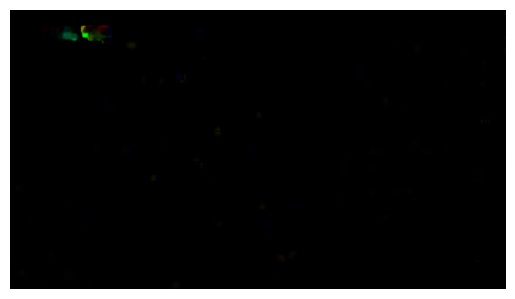

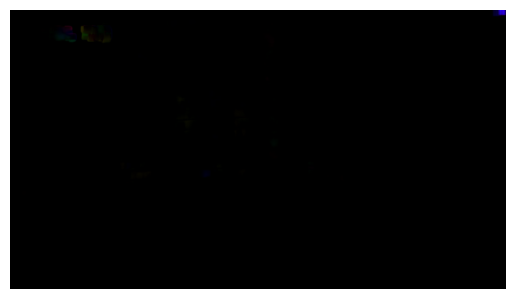

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/highgui/src/window.cpp:1006: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [13]:
#i) Fir every previous frame as reference
#Snapshots of dense optical flow is taken every 30 sec of video and printed below for reference
opticalFlow(1)

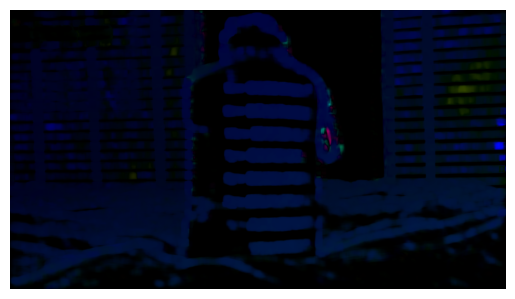

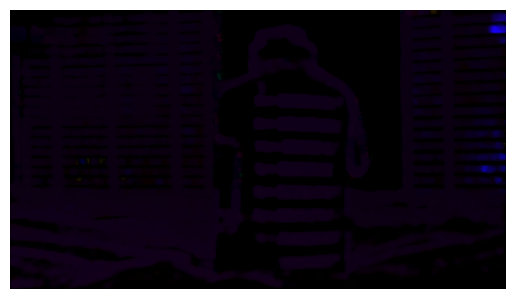

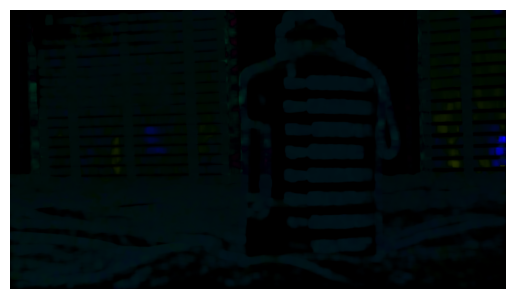

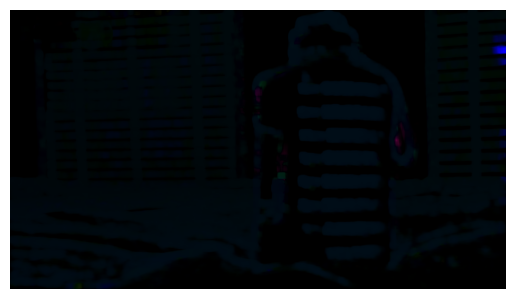

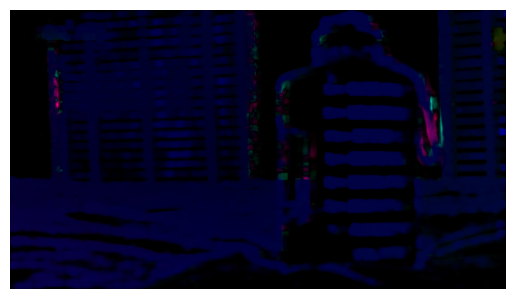

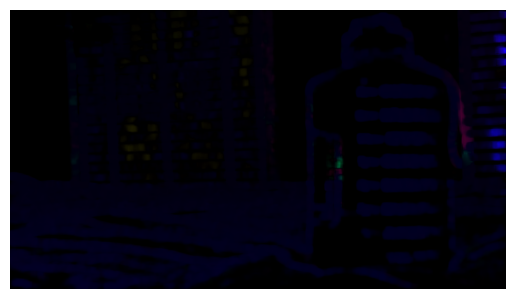

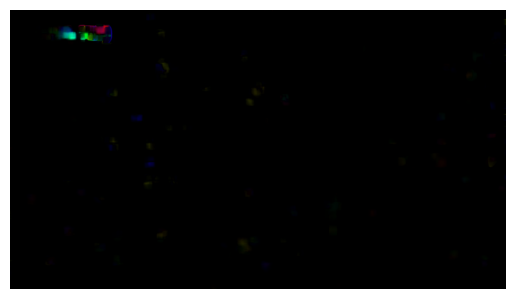

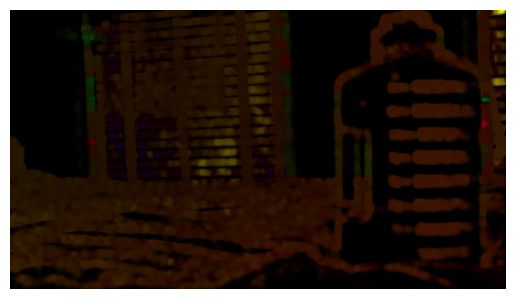

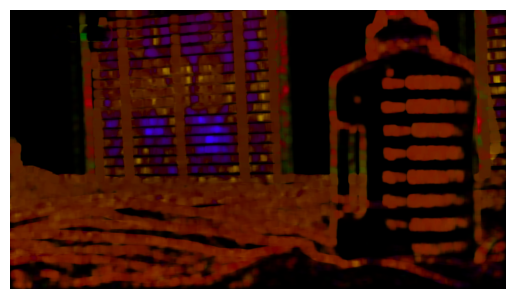

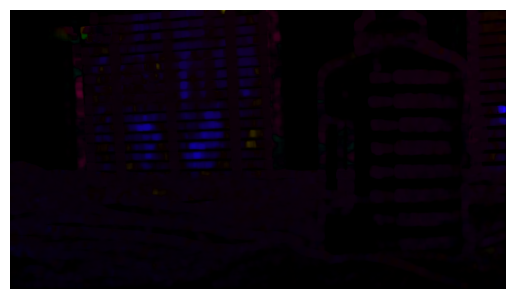

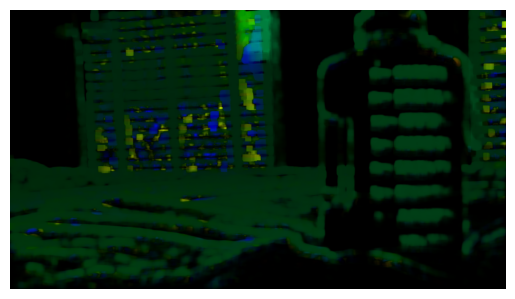

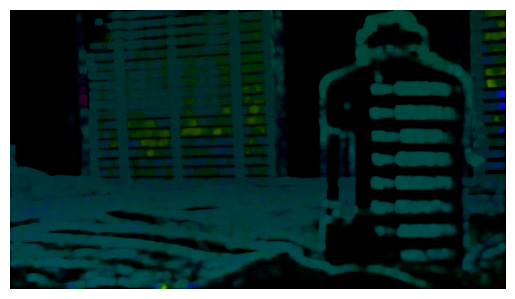

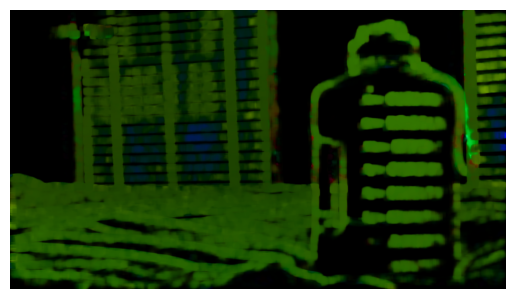

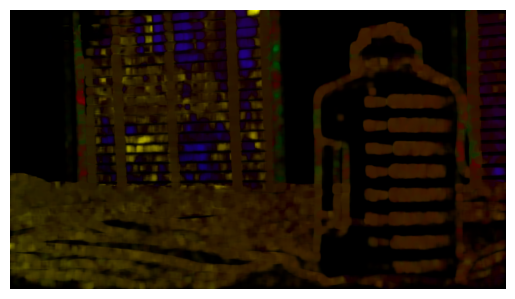

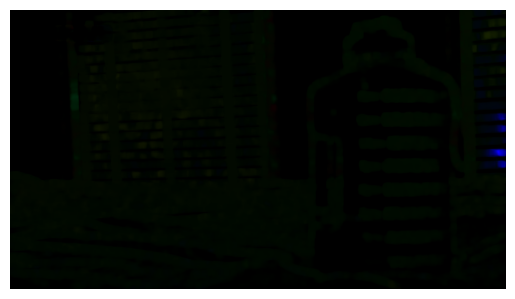

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/highgui/src/window.cpp:1006: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [14]:
#(ii) treating every 11th frame as a reference frame
##Snapshots of   dense optical flow is taken every 30 sec of video and printed below for reference
opticalFlow(11)

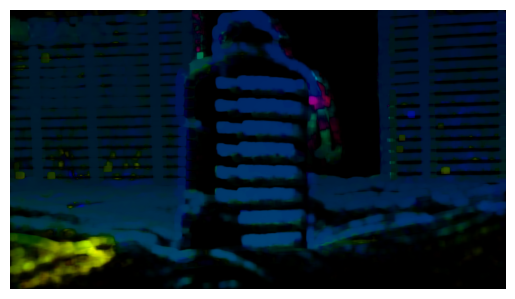

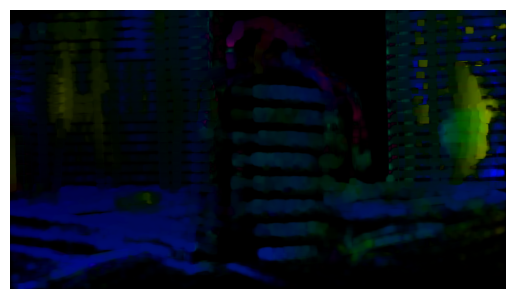

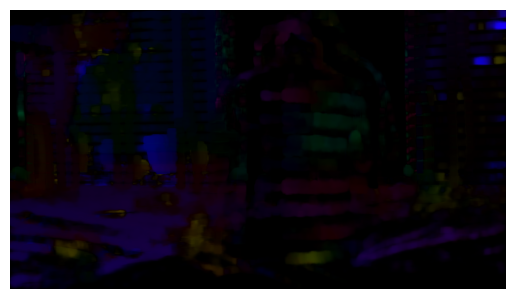

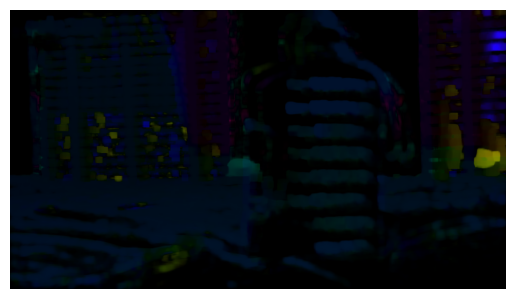

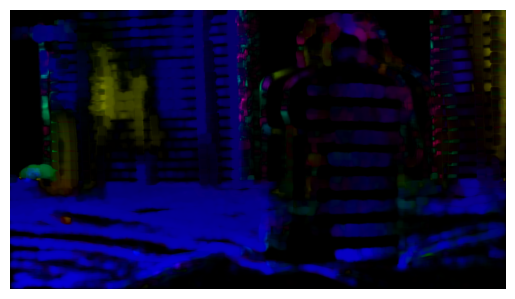

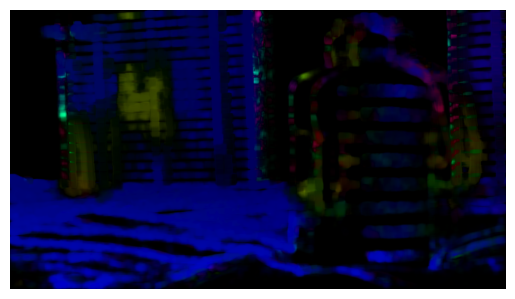

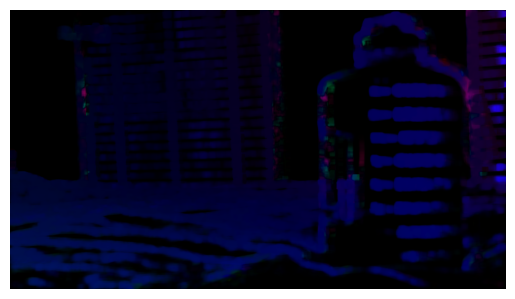

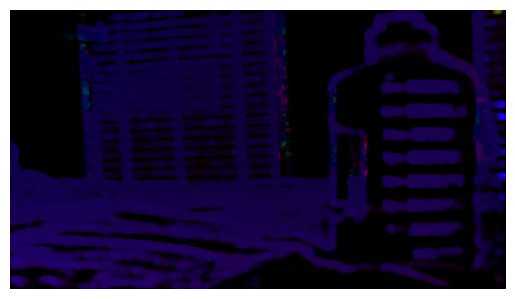

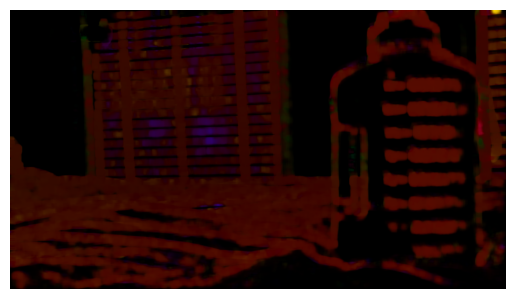

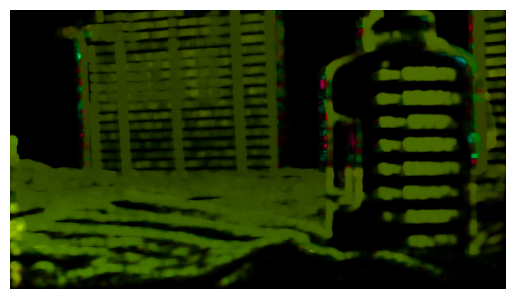

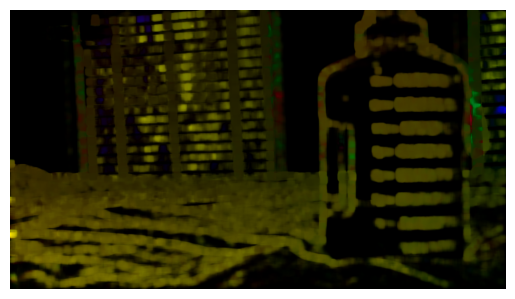

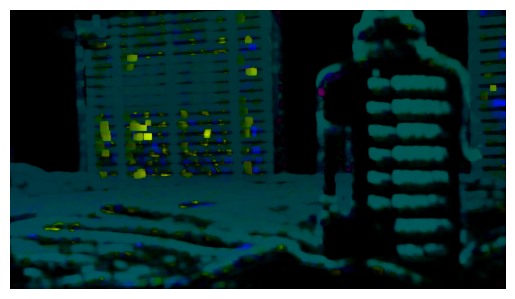

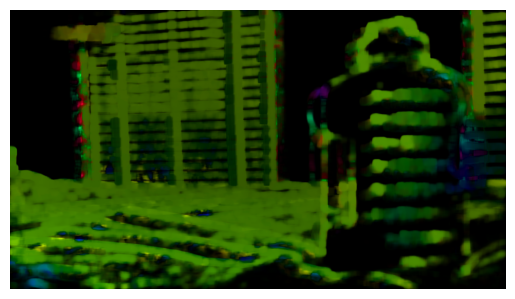

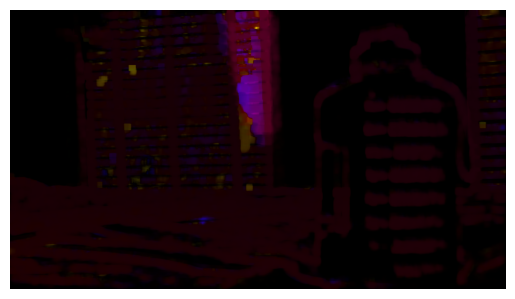

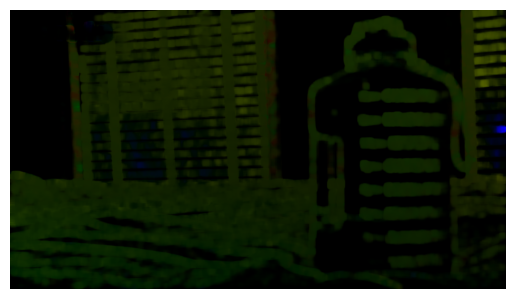

error: OpenCV(4.5.4-dev) /Users/runner/work/opencv-python/opencv-python/opencv/modules/highgui/src/window.cpp:1006: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [15]:
#(iii) treating every 31th frame as a reference frame
##Snapshots of dense optical flow is taken every 30 sec of video and printed below for reference
opticalFlow(31)

In [16]:
#question3 ends here

In [17]:
'''4. Implement a feature based object detection application (from scratch) for detecting an object of
your choice. Test it for at least 2 differently looking objects. Validate your results by testing against
built-in object detection functions/code in MATLAB/OpenCV.'''

'4. Implement a feature based object detection application (from scratch) for detecting an object of\nyour choice. Test it for at least 2 differently looking objects. Validate your results by testing against\nbuilt-in object detection functions/code in MATLAB/OpenCV.'

objects were found in this image.


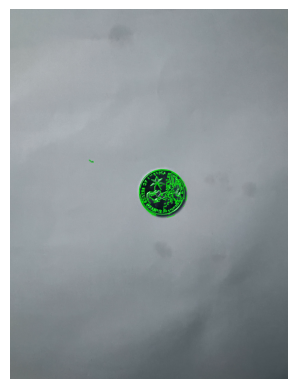

objects were found in this image.


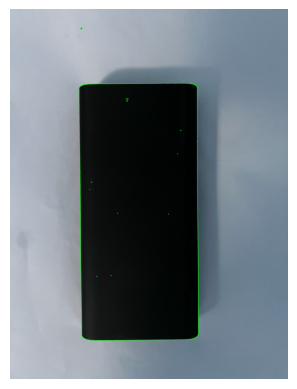

In [18]:
#Detecting objects from scratch using contour detection
def objectDetectionFromScratch(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    edged = cv2.Canny(blurred, 10, 100)

    # define a (3, 3) structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # apply the dilation operation to the edged image
    dilate = cv2.dilate(edged, kernel, iterations=1)

    # find the contours in the dilated image
    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_copy = image.copy()
    # draw the contours on a copy of the original image
    cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
    print("objects were found in this image.")
    plt.axis('off')
    plt.imshow(image_copy,cmap='gray', vmin=0, vmax=255)
    plt.show()
    
img1 = "../supportingFiles/1.jpeg"
img2 = "../supportingFiles/2.jpeg"
objectDetectionFromScratch(img1)
objectDetectionFromScratch(img2)

In [19]:
#question4 ends here

In [20]:
'''5. Implement a real-time face tracking application that will detect as many faces there are with a
scene, and identify the person’s facial region (draw a bounding box) whose is sought for by the user
(you must ask for a person in your application and it should show a bounding box over the person
of interest). Validate at least 20 times and present the recognition performance metrics (accuracy,
precision, recall and Intersection over Union (IoU)).'''

'5. Implement a real-time face tracking application that will detect as many faces there are with a\nscene, and identify the person’s facial region (draw a bounding box) whose is sought for by the user\n(you must ask for a person in your application and it should show a bounding box over the person\nof interest). Validate at least 20 times and present the recognition performance metrics (accuracy,\nprecision, recall and Intersection over Union (IoU)).'

In [ ]:
#Multiple Face Detection using Haar-Cascade

face_detector_model = cv2.CascadeClassifier('../supportingFiles/facefrontal.xml')

# reading the input image now
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector_model.detectMultiScale(gray,1.1, 4 )
    for (x,y, w, h) in faces:
        cv2.putText(frame, "Person1", (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        cv2.rectangle(frame, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  3)
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.imshow("window", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

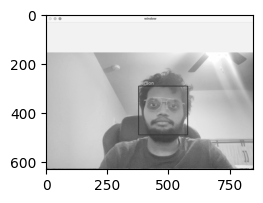

In [21]:
#Detect faces
patch= cv2.imread("../supportingFiles/face.png", 0)
plt.figure(figsize = (20,2))
plt.imshow(patch,cmap='gray', vmin=0, vmax=255)
plt.show()

In [2]:
# After testing with live faces and random objects
# TP : 8 FP: 9 TN: 2 FN: 0
# Accuracy  = (TruePositives + FalsePositives) / (TruePositives + FalsePositives + FalseNegatives + TrueNegatives)
# Accuracy = 19/20 = 0.8 (approx)
# Precision = TruePositives / (TruePositives + FalsePositives)
# Precision = 10 / 19 = 0.5 (approx)
# Recall = TruePositives / (TruePositives + FalseNegatives)
# Recall = 9 / (9+0) = 1

In [3]:
#question 5 ends here

In [4]:
'''
6. Fix a marker on a wall or a flat vertical surface. From a distance D, keeping the camera stationed static
(not handheld and mounted on a tripod or placed on a flat surface), capture an image such that the marker
is registered. Then translate the camera by T units along the axis parallel to the ground (horizontal) and
then capture another image, with the marker being registered. Compute D using disparity based depth
estimation in stereo-vision theory. (Note: you can pick any value for D and T. Keep in mind that T cannot
be large as the marker may get out of view. Of course this depends on D)
'''

'\n6. Fix a marker on a wall or a flat vertical surface. From a distance D, keeping the camera stationed static\n(not handheld and mounted on a tripod or placed on a flat surface), capture an image such that the marker\nis registered. Then translate the camera by T units along the axis parallel to the ground (horizontal) and\nthen capture another image, with the marker being registered. Compute D using disparity based depth\nestimation in stereo-vision theory. (Note: you can pick any value for D and T. Keep in mind that T cannot\nbe large as the marker may get out of view. Of course this depends on D)\n'

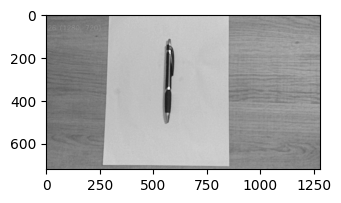

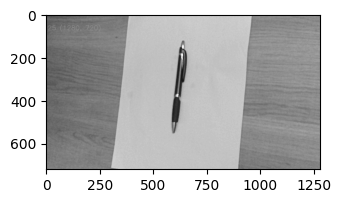

In [5]:
# Image 1 is original image with marker
# Image 2 is translated with marker
img= cv2.imread("../supportingFiles/ques6-img1.jpg", 0)
img2= cv2.imread("../supportingFiles/ques6-img2.jpg", 0)
plt.figure(figsize = (20,2))
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
plt.show()
plt.figure(figsize = (20,2))
plt.imshow(img2,cmap='gray', vmin=0, vmax=255)
plt.show()

In [6]:
# This is by manual set distance values
# D (camera away from marker to this distance)
# T (translation of the camer bt t units aong the axis parallel to ground)
D=720 
T=20
b=546.1 # distance between left and right cameras
f=1203.54736624058 #focallength
z=(b*f)/(D-T) #distance of object
print('The Disparity based depth estimation is '+str(z)+'mm')

The Disparity based depth estimation is 938.9388810056869mm
